# Hebbian FFA

Code from Paper "Emerging NeoHebbian Dynamics in Forward-Forward Learning: Implications for Neuromorphic Computing"
Authors: Erik B. Terres-Escudero, Javier Del Ser, Pablo García-Bringas

This notebook analyzed the relationship between FFA and Hebbian learning. To do so, we rely on the theoretical adaptation proposed in our paper to verify that the models achieve competitive accuracies.

In [ ]:
import torch
import torchvision
import torch.nn.functional as F 

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import json
import numpy as np

In [ ]:
# We wont require from gradients for most experiments
torch.set_grad_enabled(False)

### Hyperparameters

In [ ]:
batch_size = 1
num_steps = 24

### Datasets

In [1]:
train_MNIST = torchvision.datasets.MNIST(
    './../data/mnist', train=True, download=False, transform=torchvision.transforms.ToTensor()
)

test_MNIST = torchvision.datasets.MNIST(
    './../data/mnist', train=False, download=False, transform=torchvision.transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_MNIST, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_MNIST, batch_size = batch_size, shuffle = False)

### Output Traces

In [2]:
class ReLU_Trace:
    def __init__(self, batch_size, num_neurons, factor = 10) -> None:
        self.out_trace = torch.zeros(batch_size, num_neurons)
        
        self.factor = factor
    
    def update_trace(self, spike):
        self.out_trace = self.out_trace + spike / self.factor
    
    def get_derivative(self):
        return (self.x > 0).float()
    
    def reset_trace(self):
        self.out_trace = torch.zeros_like(self.out_trace)
    

class LI_Trace:
    def __init__(self, batch_size, num_neurons, trace_tau = 0.85) -> None:
        self.out_trace = torch.zeros(batch_size, num_neurons)
        
        self.tau = trace_tau
    
    def update_trace(self, spike):
        self.out_trace = self.out_trace * self.tau + (1 - self.tau) * spike
        
    def get_derivative(self):
        return (self.x > 0).float()

    def reset_trace(self):
        self.out_trace = torch.zeros_like(self.out_trace)


class Hard_LI_Trace:
    def __init__(self, batch_size, num_neurons, trace_tau = 0.85) -> None:
        self.out_trace = torch.zeros(batch_size, num_neurons)
        
        self.tau = trace_tau

    def update_trace(self, spike):
        self.out_trace *= self.tau 
        self.out_trace[spike] = 1

    def get_derivative(self):
        return (self.x > 0).float()

    def reset_trace(self):
        self.out_trace = torch.zeros_like(self.out_trace)

In [3]:
class Standard_Probability:
    def __init__(self, num_inputs, num_neurons, theta=1, scale_factor=6, use_et = True, nu = 0.1, tau = 0.01) -> None:       
        self.scale_factor = scale_factor
        self.theta = theta
        
        self.use_et = use_et
        
        self.nu = nu
        self.tau = tau
        
        self.elasticity_trace = torch.zeros(num_inputs, num_neurons)
        
        self.trace_history = []
        self.neuromodulation_history = []
    
    def compute_neuromodulation(self, out_trace):
        trace_norm = torch.norm(out_trace, dim = 1).pow(2)
        self.trace_history.append(trace_norm.mean())
        
        neuromodulation = torch.sigmoid(self.scale_factor * ( trace_norm - self.theta ) )
        self.neuromodulation_history.append(neuromodulation.mean())
        
        return neuromodulation
    
    def compute_probs(self, out_trace):
        trace_norm = torch.norm(out_trace, dim = 1).pow(2)
        
        return torch.sigmoid(self.scale_factor * ( trace_norm - self.theta ) )
    
    
    def hebbian_update(self, weights, x, out_trace, real_positivity):
        
        delta_weights = x.squeeze(2).unsqueeze(2) @ out_trace.unsqueeze(1)
        
        neuron_positivity = self.compute_neuromodulation(out_trace)
        
        
        if self.use_et:
            self.elasticity_trace *= (1 - self.tau)
            self.elasticity_trace += self.tau * ((1-real_positivity-neuron_positivity).unsqueeze(1).unsqueeze(2) * delta_weights).mean(dim = 0)
            weights += self.nu * self.elasticity_trace
        else:
            weights += self.nu * ((1-real_positivity-neuron_positivity).unsqueeze(1).unsqueeze(2) * delta_weights).mean(dim = 0)

        return weights


class Symmetric_Probability:
    def __init__(self, num_inputs, num_neurons, use_et = True, nu = 0.1, tau = 0.01) -> None:
        self.use_et = use_et
        
        self.num_neurons = num_neurons
        self.num_inputs = num_inputs
        
        self.elasticity_trace = torch.zeros(num_inputs, num_neurons)
        
        self.nu = nu
        self.tau = tau
    
    def compute_neuromodulation(self, out_trace, positivity):
        trace_norm_positive = torch.norm(out_trace[:,:self.num_neurons//2], dim = 1).pow(2)
        trace_norm_negative = torch.norm(out_trace[:,self.num_neurons//2:], dim = 1).pow(2)
        
        trace_ratio = (trace_norm_negative+0.01) / (trace_norm_positive + 0.01)
        trace_sum = 1 / (trace_norm_positive + trace_norm_negative + 0.01)
        
        trace_ratio = trace_ratio ** (1-2*positivity)

        return (trace_ratio * trace_sum, -1 * trace_sum)
    
    def compute_probs(self, out_trace):
        trace_norm_positive = torch.norm(out_trace[:,:self.num_neurons//2], dim = 1).pow(2)
        trace_norm_negative = torch.norm(out_trace[:,self.num_neurons//2:], dim = 1).pow(2)
        
        
        return (trace_norm_positive+0.01) / (trace_norm_positive + trace_norm_negative + 0.02)
    

    def hebbian_update(self, weights, x, out_trace, real_positivity):
        
        delta_weights = x.squeeze(2).unsqueeze(2) @ out_trace.unsqueeze(1)
        
        
        pos_part, neg_part = self.compute_neuromodulation(out_trace, real_positivity)
        
        
        rewards = (1 - real_positivity) * pos_part + real_positivity * neg_part # [R_i, -1, R_i]
        delta_weights[:,:,:self.num_neurons//2] *= rewards.unsqueeze(1).unsqueeze(2)
        
        rewards = (1 - real_positivity) * neg_part + real_positivity * pos_part # [R_i, -1, R_i]
        delta_weights[:,:,self.num_neurons//2:] *= rewards.unsqueeze(1).unsqueeze(2)
        
        if self.use_et:
            self.elasticity_trace *= (1 - self.tau)
            self.elasticity_trace += self.tau * (delta_weights).mean(dim = 0)
                        
            weights += self.nu * self.elasticity_trace.detach().clone()
            
        else:
            weights += self.nu * (delta_weights).mean(dim = 0)
            
        return weights

## Spiking Layer

In [4]:
class LIF_Layer:
    def __init__(self, batch_size, num_inputs, num_neurons, threshold = 2, tau = 0.85, topk = 10):
        # Dimension Values
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        
        # Hyperparameters
        self.batch_size = batch_size
        self.topk = topk
        self.threshold_value = threshold

        self.tau = tau

        # State
        self.weights = torch.randn(num_inputs, num_neurons)
        self.membrane_potential = torch.zeros(batch_size, num_neurons)
        self.threshold = torch.ones(batch_size, num_neurons) * threshold
        self.spike = torch.zeros(batch_size, num_neurons)
        
        
        ## Extras
        self.out_trace = None
        self.probabilities = None
        
    def set_out_trace(self, out_trace):
        self.out_trace = out_trace

    def set_probabilities(self, probabilities):
        self.probabilities = probabilities

    def set_update(self, update):
        self.update = update
        
    def forward(self, x):
        self.membrane_potential = self.membrane_potential * self.tau + x.squeeze(2) @ self.weights
        
        differential_membrane = self.membrane_potential - self.threshold + 0.01 *  torch.randn(self.num_neurons) 
        
        topk, indices = torch.topk(differential_membrane, self.topk, dim = 1)
        possible_membrane_potential = self.membrane_potential * (differential_membrane > topk[...,-1,None] - 0.001).float()
    
        self.spike = possible_membrane_potential > 0.001
        self.membrane_potential[self.spike] = 0
                
        self.out_trace.update_trace(self.spike)
        
        return self.spike.float()
    
    def __call__(self, x):
        return self.forward(x)
    
    def reset_trace(self):
        self.out_trace.reset_trace()
    
    def compute_neuromodulation(self):
        return self.probabilities.compute_neuromodulation(self.out_trace.out_trace)
    
        
    def compute_probs(self):
        return self.probabilities.compute_probs(self.out_trace.out_trace)
    
    def hebbian_update(self, x, real_positivity, out = None):
        self.weights = self.probabilities.hebbian_update(self.weights, x, self.out_trace.out_trace, real_positivity)

## Spiking Training Process

In [5]:
# Hyperaparameters
num_neurons = 200
INPUT_STRENGTH = 0.25

out_trace = ReLU_Trace(batch_size, num_neurons, factor=200)
#probability = Symmetric_Probability(28*28 + 100, num_neurons, nu=0.1, tau=0.01)
probability = Standard_Probability(28*28 + 100, num_neurons, nu=10, tau=0.01, theta = 0.5)

layer = LIF_Layer(batch_size, 28*28 +100, num_neurons, topk=200, tau=0.85)
layer.set_out_trace(out_trace)
layer.set_probabilities(probability)

labels = torch.bernoulli(torch.ones((10, 100)) * 0.3).long()

In [27]:
def train_network(layer, labels, use_eval = False,  max_i = 10000000):
    is_eval = False

    # Metrics
    historic_positivity = []
    historic_probability = []

    cor, tot, cor_t, tot_t = 0, 0, 0, 0
    c_m = [[0,0], [0,0]]
        
    # NOTE: This function does not properly behave as an evaluation function during trainnig. Only use to measure approximate accuracies.
    def eval_step(x, y):
        global cor, tot, cor_t, tot_t
                
        goodnesses = torch.zeros((x.shape[0], 10))
        for label in range(10):
            layer.reset_trace()
            x_pos = torch.cat((x.reshape(x.shape[0],784,1), labels[label * torch.ones_like(y)].long().reshape(x.shape[0],100,1)), dim = 1)
            
            pre_x = INPUT_STRENGTH * x_pos.reshape((x.shape[0], 28 * 28 + 100))
            pre_x = pre_x.unsqueeze(2).repeat(1,1,num_steps)
            enc_x = torch.bernoulli(pre_x)
            
            for t in range(num_steps-1):
                enc_x_t = enc_x[:, :, t].reshape((x.shape[0], 28*28+100, 1))

                out = layer(enc_x_t)

            inference_probs = layer.compute_probs()
            goodnesses[:, label] = inference_probs
            
            layer.reset_trace()
            for t in range(20):
                out = layer(torch.zeros_like(enc_x_t))
                
        # Check if the max goodness is correct with the y
        _, max_goodness = torch.max(goodnesses, dim = 1)
        cor_t += (max_goodness == y).sum()
        tot_t += x.shape[0]

    for i, (x, y) in (pbar := tqdm(enumerate(train_loader))):
        pbar.set_description("Acc: %i/%i (%.2f)  | Acc Test %i/%i (%.2f) ACt [%.2f] [%s] | %.3f - %.3f" % (cor, tot, cor/max(tot,1) ,cor_t, tot_t, cor_t/max(tot_t,1), layer.out_trace.out_trace.mean(), c_m, layer.membrane_potential.min(), layer.out_trace.out_trace.max()))
        x_copy = x.clone()
        c_m = [[0,0], [0,0]]   
        
        if i > max_i: break
        
        # Create lables
        y_positivity = torch.randint(0, 2, (x.shape[0],))
        y_labels = (y + y_positivity * torch.randint(1, 10, (x.shape[0],))) % 10
        
        # Create image
        x_post = torch.cat((x.reshape(x.shape[0],784,1), labels[y_labels.long()].long().reshape(x.shape[0],100,1)), dim = 1)
        pre_x = INPUT_STRENGTH * x_post.reshape((x.shape[0], 28 * 28 + 100))
        pre_x = pre_x.unsqueeze(2).repeat(1,1,num_steps)
        enc_x = torch.bernoulli(pre_x)

        # Forward pass
        for t in range(num_steps-1):
            enc_x_t = enc_x[:, :, t].reshape((x.shape[0], 28*28+100, 1))

            out = layer(enc_x_t)
            if t > 15: layer.hebbian_update(enc_x_t, y_positivity)
        
        # Include the statistics
        
        inference_probs = layer.compute_probs()
        historic_positivity += [y_positivity[0].item()]
        historic_probability += [inference_probs[0].item()]
        
        c_m[0][0] += (inference_probs[y_positivity == 0] > 0.5).sum()
        c_m[0][1] += (inference_probs[y_positivity == 1] > 0.5).sum()
        c_m[1][0] += (inference_probs[y_positivity == 0] < 0.5).sum()
        c_m[1][1] += (inference_probs[y_positivity == 1] < 0.5).sum()

        cor += c_m[0][0] + c_m[1][1]
        tot += x.shape[0]
        
        # Rest
        for t in range(20):
            out = layer(torch.zeros_like(enc_x_t))
        layer.reset_trace()
            
        #if tot > 4000: raise Exception()
        
        if use_eval:
            eval_step(x_copy, y)
    
    return layer

def test(layer, max_i = 10000000):
    cor, tot = 0, 0
    c_m = [[0,0], [0,0]]
    
    for i, (x, y) in (pbar := tqdm(enumerate(test_loader))):
        pbar.set_description("Acc: %i/%i (%.2f)  | ACt [%.2f] [%s] | %.3f - %.3f" % (cor, tot, cor/max(tot,1) , layer.out_trace.out_trace.mean(), c_m, layer.membrane_potential.min(), layer.out_trace.out_trace.max()))
      
        if i > max_i: break
        
        goodnesses = torch.zeros((x.shape[0], 10))
        for label in range(10):
            layer.reset_trace()
            
            # Create the input
            x_pos = torch.cat((x.reshape(x.shape[0],784,1), labels[label * torch.ones_like(y)].long().reshape(x.shape[0],100,1)), dim = 1)
            
            pre_x = INPUT_STRENGTH * x_pos.reshape((x.shape[0], 28 * 28 + 100))
            pre_x = pre_x.unsqueeze(2).repeat(1,1,num_steps)
            enc_x = torch.bernoulli(pre_x)
            
            for t in range(num_steps-1):
                enc_x_t = enc_x[:, :, t].reshape((x.shape[0], 28*28+100, 1))

                out = layer(enc_x_t)

            inference_probs = layer.compute_probs()
            goodnesses[:, label] = inference_probs
            
            for t in range(20):
                out = layer(torch.zeros_like(enc_x_t))
                
        # Check if the max goodness is correct with the y
        _, max_goodness = torch.max(goodnesses, dim = 1)
        cor += (max_goodness == y).sum()
        tot += x.shape[0]
    
    return cor, tot


### Hyperparameter search

In [7]:
import json

out_traces = [ReLU_Trace(batch_size, num_neurons, factor=200), LI_Trace(batch_size, num_neurons), Hard_LI_Trace(batch_size, num_neurons)]
probabilities = [Standard_Probability(28*28 + 100, num_neurons, nu=0.1, tau=0.01), Symmetric_Probability(28*28 + 100, num_neurons, nu=0.1, tau=0.01)]

results = {}
# Read file results.json
with open("results_real_batchless.json", "r") as file:
    results = json.load(file)

for topk_val in [200, 20]:
    for out_trace_name in ["ReLU", "Standard", "Ororbia"]:
        
        if out_trace_name == "ReLU": out_trace_val = ReLU_Trace(batch_size, num_neurons, factor=100)
        elif out_trace_name == "Standard": out_trace_val = LI_Trace(batch_size, num_neurons)
        else: out_trace_val = Hard_LI_Trace(batch_size, num_neurons)
        
        for nu_t in [0.01, 0.1, 1, 10]: # Learning rate
            for tau in [0.01, 0.1, 0.001]: # Eligibility Decay
                for probability_name in ["Standard", "Symmetric"]:
                    
                    final_name = f"Layer_{topk_val}_{out_trace_val.__class__.__name__}_{nu_t}_{tau}_{probability_name}"
                    print(f"Currently at {final_name}")
                    
                    if final_name in results: continue
                    
                    labels = torch.bernoulli(torch.ones((10, 100)) * 0.3).long()
                    
                    if probability_name == "Standard": probability = Standard_Probability(28*28 + 100, num_neurons, nu=nu_t, tau=tau, theta=0.5)
                    else: probability = Symmetric_Probability(28*28 + 100, num_neurons, nu=nu_t, tau=tau)
                        
                    layer = LIF_Layer(batch_size, 28*28 +100, num_neurons, topk=topk_val, tau=0.85)
                    layer.set_out_trace(out_trace_val)
                    layer.set_probabilities(probability)
                    
                    layer = train_network(layer, use_eval = False)
                    cor, tot = test(layer)
                    
                    results[final_name] = float(cor / tot)
                    
                    with open("results_real_batchless.json", "w") as file:
                        json.dump(results, file)

Currently at Layer_200_ReLU_Out_Trace_1_0.01_Standard
Currently at Layer_200_ReLU_Out_Trace_1_0.01_Symmetric
Currently at Layer_200_ReLU_Out_Trace_1_0.1_Standard
Currently at Layer_200_ReLU_Out_Trace_1_0.1_Symmetric
Currently at Layer_200_ReLU_Out_Trace_1_0.001_Standard
Currently at Layer_200_ReLU_Out_Trace_1_0.001_Symmetric
Currently at Layer_200_ReLU_Out_Trace_10_0.01_Standard
Currently at Layer_200_ReLU_Out_Trace_10_0.01_Symmetric
Currently at Layer_200_ReLU_Out_Trace_10_0.1_Standard
Currently at Layer_200_ReLU_Out_Trace_10_0.1_Symmetric
Currently at Layer_200_ReLU_Out_Trace_10_0.001_Standard
Currently at Layer_200_ReLU_Out_Trace_10_0.001_Symmetric
Currently at Layer_200_Standard_Out_Trace_1_0.01_Standard
Currently at Layer_200_Standard_Out_Trace_1_0.01_Symmetric
Currently at Layer_200_Standard_Out_Trace_1_0.1_Standard
Currently at Layer_200_Standard_Out_Trace_1_0.1_Symmetric
Currently at Layer_200_Standard_Out_Trace_1_0.001_Standard
Currently at Layer_200_Standard_Out_Trace_1_0.001

0it [00:00, ?it/s]

Acc: 53804/59999 (0.90)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -18266.689 - 0.000: : 60000it [47:35, 21.02it/s]
Acc: 8166/9999 (0.82)  | ACt [0.00] [[[0, 0], [0, 0]]] | -16479.084 - 0.230: : 10000it [21:25,  7.78it/s]


Currently at Layer_20_ReLU_Out_Trace_1_0.001_Standard


Acc: 30018/59999 (0.50)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -1.571 - 0.000: : 60000it [28:42, 34.83it/s]
Acc: 1007/9999 (0.10)  | ACt [0.03] [[[0, 0], [0, 0]]] | -1.826 - 0.230: : 10000it [20:01,  8.32it/s]


Currently at Layer_20_ReLU_Out_Trace_1_0.001_Symmetric


Acc: 44872/59999 (0.75)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -2630380.250 - 0.000: : 60000it [34:09, 29.27it/s]
Acc: 6047/9999 (0.60)  | ACt [0.00] [[[0, 0], [0, 0]]] | -2672728.250 - 0.180: : 10000it [20:50,  8.00it/s]


Currently at Layer_20_ReLU_Out_Trace_10_0.01_Standard


Acc: 29881/59999 (0.50)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -2.780 - 0.000: : 60000it [32:38, 30.64it/s]
Acc: 1060/9999 (0.11)  | ACt [0.03] [[[0, 0], [0, 0]]] | -2.367 - 0.230: : 10000it [21:42,  7.67it/s]


Currently at Layer_20_ReLU_Out_Trace_10_0.01_Symmetric


Acc: 30052/59999 (0.50)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -10178075.000 - 0.000: : 60000it [36:53, 27.11it/s]
Acc: 1020/9999 (0.10)  | ACt [0.00] [[[0, 0], [0, 0]]] | -10738423.000 - 0.000: : 10000it [21:42,  7.68it/s]


Currently at Layer_20_ReLU_Out_Trace_10_0.1_Standard


Acc: 29952/59999 (0.50)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -1.579 - 0.000: : 60000it [33:07, 30.18it/s]
Acc: 1154/9999 (0.12)  | ACt [0.03] [[[0, 0], [0, 0]]] | -2.260 - 0.230: : 10000it [32:16,  5.16it/s]


Currently at Layer_20_ReLU_Out_Trace_10_0.1_Symmetric


Acc: 46664/59999 (0.78)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -3100358.500 - 0.000: : 60000it [41:36, 24.03it/s]
Acc: 5655/9999 (0.57)  | ACt [0.00] [[[0, 0], [0, 0]]] | -2919160.250 - 0.180: : 10000it [22:21,  7.45it/s]


Currently at Layer_20_ReLU_Out_Trace_10_0.001_Standard


Acc: 29933/59999 (0.50)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -1.961 - 0.000: : 60000it [34:44, 28.78it/s]
Acc: 1006/9999 (0.10)  | ACt [0.03] [[[0, 0], [0, 0]]] | -2.010 - 0.230: : 10000it [24:27,  6.82it/s]


Currently at Layer_20_ReLU_Out_Trace_10_0.001_Symmetric


Acc: 29873/59999 (0.50)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(1)], [tensor(0), tensor(0)]]] | -58255532.000 - 0.000: : 60000it [36:15, 27.59it/s] 
Acc: 1013/9999 (0.10)  | ACt [0.00] [[[0, 0], [0, 0]]] | -63369064.000 - 0.000: : 10000it [17:09,  9.71it/s]


Currently at Layer_20_Standard_Out_Trace_1_0.01_Standard


Acc: 51505/59999 (0.86)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -127.235 - 0.000: : 60000it [28:40, 34.88it/s]
Acc: 8071/9999 (0.81)  | ACt [0.00] [[[0, 0], [0, 0]]] | -156.062 - 0.000: : 10000it [17:50,  9.34it/s]


Currently at Layer_20_Standard_Out_Trace_1_0.01_Symmetric


Acc: 50267/59999 (0.84)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -38268.227 - 0.000: : 60000it [31:18, 31.94it/s]
Acc: 8050/9999 (0.81)  | ACt [0.00] [[[0, 0], [0, 0]]] | -23128.914 - 0.038: : 10000it [17:46,  9.38it/s]


Currently at Layer_20_Standard_Out_Trace_1_0.1_Standard


Acc: 52854/59999 (0.88)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -155.290 - 0.000: : 60000it [28:49, 34.69it/s]
Acc: 8506/9999 (0.85)  | ACt [0.00] [[[0, 0], [0, 0]]] | -108.075 - 0.012: : 10000it [17:44,  9.39it/s]


Currently at Layer_20_Standard_Out_Trace_1_0.1_Symmetric


Acc: 54338/59999 (0.91)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -1929.606 - 0.000: : 60000it [31:55, 31.32it/s]
Acc: 8712/9999 (0.87)  | ACt [0.00] [[[0, 0], [0, 0]]] | -1579.007 - 0.035: : 10000it [17:52,  9.33it/s]


Currently at Layer_20_Standard_Out_Trace_1_0.001_Standard


Acc: 47482/59999 (0.79)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -223.703 - 0.000: : 60000it [27:48, 35.97it/s]
Acc: 5854/9999 (0.59)  | ACt [0.00] [[[0, 0], [0, 0]]] | -157.088 - 0.022: : 10000it [17:38,  9.45it/s]


Currently at Layer_20_Standard_Out_Trace_1_0.001_Symmetric


Acc: 51440/59999 (0.86)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -366323.781 - 0.000: : 60000it [30:46, 32.49it/s] 
Acc: 8036/9999 (0.80)  | ACt [0.00] [[[0, 0], [0, 0]]] | -314246.031 - 0.028: : 10000it [17:49,  9.35it/s]


Currently at Layer_20_Standard_Out_Trace_10_0.01_Standard


Acc: 47038/59999 (0.78)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -1699.938 - 0.000: : 60000it [28:08, 35.53it/s]
Acc: 5884/9999 (0.59)  | ACt [0.00] [[[0, 0], [0, 0]]] | -1259.171 - 0.033: : 10000it [17:42,  9.41it/s]


Currently at Layer_20_Standard_Out_Trace_10_0.01_Symmetric


Acc: 51773/59999 (0.86)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -5101209.000 - 0.000: : 60000it [31:01, 32.23it/s]
Acc: 8300/9999 (0.83)  | ACt [0.00] [[[0, 0], [0, 0]]] | -3454225.000 - 0.038: : 10000it [17:50,  9.35it/s]


Currently at Layer_20_Standard_Out_Trace_10_0.1_Standard


Acc: 49693/59999 (0.83)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -1747.136 - 0.000: : 60000it [28:29, 35.11it/s]
Acc: 5986/9999 (0.60)  | ACt [0.00] [[[0, 0], [0, 0]]] | -1451.615 - 0.001: : 10000it [17:48,  9.36it/s]


Currently at Layer_20_Standard_Out_Trace_10_0.1_Symmetric


Acc: 50195/59999 (0.84)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(1)], [tensor(0), tensor(0)]]] | -413373.750 - 0.000: : 60000it [31:21, 31.89it/s] 
Acc: 8063/9999 (0.81)  | ACt [0.00] [[[0, 0], [0, 0]]] | -426896.781 - 0.036: : 10000it [17:52,  9.32it/s]


Currently at Layer_20_Standard_Out_Trace_10_0.001_Standard


Acc: 34531/59999 (0.58)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -184.912 - 0.000: : 60000it [27:36, 36.21it/s] 
Acc: 2013/9999 (0.20)  | ACt [0.00] [[[0, 0], [0, 0]]] | -1537.276 - 0.022: : 10000it [17:41,  9.42it/s]


Currently at Layer_20_Standard_Out_Trace_10_0.001_Symmetric


Acc: 46938/59999 (0.78)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -46160548.000 - 0.000: : 60000it [30:32, 32.73it/s] 
Acc: 6528/9999 (0.65)  | ACt [0.00] [[[0, 0], [0, 0]]] | -42059944.000 - 0.033: : 10000it [19:08,  8.71it/s]


Currently at Layer_20_Ororbia_Out_Trace_1_0.01_Standard


Acc: 43215/59999 (0.72)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -96.475 - 0.000: : 60000it [35:12, 28.41it/s] 
Acc: 5170/9999 (0.52)  | ACt [0.00] [[[0, 0], [0, 0]]] | -85.810 - 0.000: : 10000it [25:46,  6.47it/s]


Currently at Layer_20_Ororbia_Out_Trace_1_0.01_Symmetric


Acc: 50330/59999 (0.84)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -25106.424 - 0.000: : 60000it [35:52, 27.87it/s]
Acc: 7617/9999 (0.76)  | ACt [0.00] [[[0, 0], [0, 0]]] | -14373.590 - 0.039: : 10000it [18:45,  8.88it/s]


Currently at Layer_20_Ororbia_Out_Trace_1_0.1_Standard


Acc: 48765/59999 (0.81)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -82.744 - 0.000: : 60000it [28:06, 35.58it/s] 
Acc: 6638/9999 (0.66)  | ACt [0.00] [[[0, 0], [0, 0]]] | -83.373 - 0.000: : 10000it [20:03,  8.31it/s]


Currently at Layer_20_Ororbia_Out_Trace_1_0.1_Symmetric


Acc: 53198/59999 (0.89)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -755.744 - 0.000: : 60000it [42:02, 23.78it/s] 
Acc: 8493/9999 (0.85)  | ACt [0.00] [[[0, 0], [0, 0]]] | -1049.630 - 0.039: : 10000it [18:58,  8.78it/s]


Currently at Layer_20_Ororbia_Out_Trace_1_0.001_Standard


Acc: 35190/59999 (0.59)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -113.844 - 0.000: : 60000it [28:42, 34.84it/s]
Acc: 2954/9999 (0.30)  | ACt [0.00] [[[0, 0], [0, 0]]] | -98.592 - 0.000: : 10000it [20:02,  8.31it/s]


Currently at Layer_20_Ororbia_Out_Trace_1_0.001_Symmetric


Acc: 45683/59999 (0.76)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -770955.312 - 0.000: : 60000it [35:28, 28.20it/s] 
Acc: 6236/9999 (0.62)  | ACt [0.00] [[[0, 0], [0, 0]]] | -485366.281 - 0.039: : 10000it [26:21,  6.32it/s]


Currently at Layer_20_Ororbia_Out_Trace_10_0.01_Standard


Acc: 34098/59999 (0.57)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -401.331 - 0.000: : 60000it [31:35, 31.66it/s] 
Acc: 3667/9999 (0.37)  | ACt [0.00] [[[0, 0], [0, 0]]] | -804.150 - 0.000: : 10000it [23:39,  7.05it/s]


Currently at Layer_20_Ororbia_Out_Trace_10_0.01_Symmetric


Acc: 38671/59999 (0.64)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(1), tensor(0)]]] | -6833852.500 - 0.000: : 60000it [35:22, 28.27it/s] 
Acc: 4463/9999 (0.45)  | ACt [0.00] [[[0, 0], [0, 0]]] | -5489770.500 - 0.039: : 10000it [21:32,  7.74it/s]


Currently at Layer_20_Ororbia_Out_Trace_10_0.1_Standard


Acc: 40599/59999 (0.68)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -933.454 - 0.000: : 60000it [30:16, 33.03it/s] 
Acc: 5047/9999 (0.50)  | ACt [0.00] [[[0, 0], [0, 0]]] | -898.488 - 0.000: : 10000it [21:43,  7.67it/s]


Currently at Layer_20_Ororbia_Out_Trace_10_0.1_Symmetric


Acc: 29915/59999 (0.50)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(1)], [tensor(0), tensor(0)]]] | -114673.305 - 0.000: : 60000it [35:28, 28.19it/s]
Acc: 965/9999 (0.10)  | ACt [0.00] [[[0, 0], [0, 0]]] | -155081.828 - 0.000: : 10000it [24:09,  6.90it/s]


Currently at Layer_20_Ororbia_Out_Trace_10_0.001_Standard


Acc: 30089/59999 (0.50)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -216.602 - 0.000: : 60000it [38:34, 25.93it/s]
Acc: 972/9999 (0.10)  | ACt [0.00] [[[0, 0], [0, 0]]] | -199.278 - 0.000: : 10000it [23:33,  7.08it/s]


Currently at Layer_20_Ororbia_Out_Trace_10_0.001_Symmetric


Acc: 39073/59999 (0.65)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -110016784.000 - 0.000: : 60000it [32:57, 30.33it/s]
Acc: 4795/9999 (0.48)  | ACt [0.00] [[[0, 0], [0, 0]]] | -34637380.000 - 0.039: : 10000it [21:37,  7.71it/s]


#### Results in Batched Hebbian FFA

In [45]:
with open("results_real.json", "r") as file:
    results = json.load(file)

for out_trace in ["ReLU", "Standard", "Ororbia"]:
    for probability_name in ["Standard", "Symmetric"]:
        accs = []
        for result in results:
            if result.replace("Out_Trace_", '').split("_")[2] == out_trace and result.replace("Out_Trace_", '').split("_")[5] == probability_name:
                accs.append(results[result])
                
        print(f"Out Trace: {out_trace} | Probability: {probability_name} | Mean: {np.mean(accs)} | Std: {np.std(accs)} | Max: {np.max(accs)} | Min: {np.min(accs)}")
            


Out Trace: ReLU | Probability: Standard | Mean: 0.2683166652917862 | Std: 0.2562524313098202 | Max: 0.8187999725341797 | Min: 0.08709999918937683
Out Trace: ReLU | Probability: Symmetric | Mean: 0.6956233305235704 | Std: 0.24808609074705193 | Max: 0.8687999844551086 | Min: 0.09030000120401382
Out Trace: Standard | Probability: Standard | Mean: 0.32214999993642174 | Std: 0.2308684978829667 | Max: 0.7935000061988831 | Min: 0.09610000252723694
Out Trace: Standard | Probability: Symmetric | Mean: 0.668433333436648 | Std: 0.2867505002274655 | Max: 0.8895999789237976 | Min: 0.10130000114440918
Out Trace: Ororbia | Probability: Standard | Mean: 0.21673333297173183 | Std: 0.1660607738058321 | Max: 0.6367999911308289 | Min: 0.09780000150203705
Out Trace: Ororbia | Probability: Symmetric | Mean: 0.5940900027751923 | Std: 0.31034339173508535 | Max: 0.855400025844574 | Min: 0.09929999709129333


#### Results in Online Hebbian FFA

In [46]:
with open("results_real_batchless.json", "r") as file:
    results = json.load(file)

for out_trace in ["ReLU", "Standard", "Ororbia"]:
    for probability_name in ["Standard", "Symmetric"]:
        accs = []
        for result in results:
            if result.replace("Out_Trace_", '').split("_")[2] == out_trace and result.replace("Out_Trace_", '').split("_")[5] == probability_name:
                accs.append(results[result])
                
        print(f"Out Trace: {out_trace} | Probability: {probability_name} | Mean: {np.mean(accs)} | Std: {np.std(accs)} | Max: {np.max(accs)} | Min: {np.min(accs)}")
            


Out Trace: ReLU | Probability: Standard | Mean: 0.3946083337068558 | Std: 0.308105881246706 | Max: 0.8392000198364258 | Min: 0.09130000323057175
Out Trace: ReLU | Probability: Symmetric | Mean: 0.5492749996483326 | Std: 0.272880569676845 | Max: 0.8215000033378601 | Min: 0.10130000114440918
Out Trace: Standard | Probability: Standard | Mean: 0.5907416666547457 | Std: 0.19357353047576326 | Max: 0.8507000207901001 | Min: 0.2012999951839447
Out Trace: Standard | Probability: Symmetric | Mean: 0.7421500018487374 | Std: 0.20032884573479204 | Max: 0.8712999820709229 | Min: 0.10000000149011612
Out Trace: Ororbia | Probability: Standard | Mean: 0.4387416671961546 | Std: 0.19631860149317118 | Max: 0.7411999702453613 | Min: 0.09719999879598618
Out Trace: Ororbia | Probability: Symmetric | Mean: 0.5456666685640812 | Std: 0.2871427681780836 | Max: 0.8554999828338623 | Min: 0.09650000184774399


### Extensive Training

This training represents the second aspect of RQ1 of the additional training over 10 epochs.

In [9]:
import json

# Batched
config_1 = [Symmetric_Probability(28*28 + 100, num_neurons, nu=1, tau=0.1), ReLU_Trace(50, num_neurons), 200]
config_2 = [Standard_Probability(28*28 + 100, num_neurons, nu=10, tau=0.1), LI_Trace(50, num_neurons), 200]

config_3 = [Symmetric_Probability(28*28 + 100, num_neurons, nu=1, tau=0.1), LI_Trace(1, num_neurons), 200]
config_4 = [Standard_Probability(28*28 + 100, num_neurons, nu=1, tau=0.1), LI_Trace(1, num_neurons), 200]

configs = [config_1, config_2, config_3, config_4]

ii = 0
accuracies = {}
for config in configs:
    ii+=1
    print(f"\n\n Currently in {ii}")
    

    if ii == 1 or ii == 2:
        batch_size = 50
    else:
        batch_size = 1
        

    num_steps = 24
    
    train_MNIST = torchvision.datasets.MNIST('./../data/mnist', train=True, download=False, transform=torchvision.transforms.ToTensor())
    test_MNIST = torchvision.datasets.MNIST('./../data/mnist', train=False, download=False, transform=torchvision.transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(train_MNIST, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_MNIST, batch_size = batch_size, shuffle = False)
    
    
    
    accuracies[ii] = []
    
    layer = LIF_Layer(batch_size, 28*28 +100, num_neurons, topk=config[2], tau=0.85)
    layer.set_out_trace(config[1])
    layer.set_probabilities(config[0])
    
    labels = torch.bernoulli(torch.ones((10, 100)) * 0.3).long()
    
    for i in range(10):
        layer = train_network(layer, use_eval = False)
        cor, tot = test(layer)
        print(f"Accuracy: {cor / tot}")
        accuracies[ii].append(float(cor / tot))
    
    # Save model weights
    torch.save(layer.weights, f"results/models/model_{ii}.pt")
    # Save labels
    torch.save(labels, f"results/models/labels_{ii}.pt")
    
    with open("results_training_batchless_final.json", "w") as file:
        json.dump(accuracies, file)



 Currently in 1


Acc: 0/0 (0.00)  | Acc Test 0/0 (0.00) ACt [0.00] [[[0, 0], [0, 0]]] | 0.000 - 0.000: : 0it [00:00, ?it/s]

Acc: 52894/59950 (0.88)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(24), tensor(2)], [tensor(0), tensor(24)]]] | -32.998 - 0.000: : 1200it [04:18,  4.64it/s]
Acc: 8352/9950 (0.84)  | ACt [0.04] [[[0, 0], [0, 0]]] | -29.629 - 2.300: : 200it [03:11,  1.04it/s]


Accuracy: 0.8393999934196472


Acc: 56241/59950 (0.94)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(20), tensor(4)], [tensor(0), tensor(26)]]] | -61.293 - 0.000: : 1200it [04:14,  4.71it/s]
Acc: 8804/9950 (0.88)  | ACt [0.04] [[[0, 0], [0, 0]]] | -50.785 - 2.300: : 200it [03:12,  1.04it/s]


Accuracy: 0.8848000168800354


Acc: 56918/59950 (0.95)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(20), tensor(1)], [tensor(0), tensor(29)]]] | -71.061 - 0.000: : 1200it [04:13,  4.74it/s]
Acc: 9021/9950 (0.91)  | ACt [0.02] [[[0, 0], [0, 0]]] | -66.746 - 2.300: : 200it [03:13,  1.03it/s]


Accuracy: 0.9065999984741211


Acc: 56935/59950 (0.95)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(20), tensor(6)], [tensor(0), tensor(24)]]] | -118.576 - 0.000: : 1200it [04:01,  4.98it/s]
Acc: 8963/9950 (0.90)  | ACt [0.02] [[[0, 0], [0, 0]]] | -87.662 - 2.300: : 200it [03:12,  1.04it/s] 


Accuracy: 0.9007999897003174


Acc: 57234/59950 (0.95)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(19), tensor(2)], [tensor(1), tensor(28)]]] | -119.386 - 0.000: : 1200it [04:01,  4.97it/s]
Acc: 9067/9950 (0.91)  | ACt [0.03] [[[0, 0], [0, 0]]] | -109.637 - 2.300: : 200it [03:11,  1.04it/s]


Accuracy: 0.9111999869346619


Acc: 57407/59950 (0.96)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(28), tensor(0)], [tensor(1), tensor(21)]]] | -160.663 - 0.000: : 1200it [04:02,  4.95it/s]
Acc: 9076/9950 (0.91)  | ACt [0.02] [[[0, 0], [0, 0]]] | -126.956 - 2.300: : 200it [03:13,  1.03it/s]


Accuracy: 0.9121999740600586


Acc: 57336/59950 (0.96)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(20), tensor(0)], [tensor(1), tensor(29)]]] | -178.353 - 0.000: : 1200it [03:48,  5.24it/s]
Acc: 9080/9950 (0.91)  | ACt [0.02] [[[0, 0], [0, 0]]] | -134.685 - 2.300: : 200it [03:11,  1.04it/s]


Accuracy: 0.9122999906539917


Acc: 57407/59950 (0.96)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(27), tensor(1)], [tensor(0), tensor(21)]]] | -157.007 - 0.000: : 1200it [03:52,  5.16it/s]
Acc: 9166/9950 (0.92)  | ACt [0.02] [[[0, 0], [0, 0]]] | -149.469 - 2.300: : 200it [03:12,  1.04it/s]


Accuracy: 0.9211000204086304


Acc: 57579/59950 (0.96)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(23), tensor(1)], [tensor(0), tensor(26)]]] | -174.535 - 0.000: : 1200it [04:09,  4.81it/s]
Acc: 9213/9950 (0.93)  | ACt [0.02] [[[0, 0], [0, 0]]] | -178.381 - 2.300: : 200it [03:14,  1.03it/s]


Accuracy: 0.9258999824523926


Acc: 57729/59950 (0.96)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(24), tensor(0)], [tensor(0), tensor(26)]]] | -182.556 - 0.000: : 1200it [03:57,  5.05it/s]
Acc: 9229/9950 (0.93)  | ACt [0.02] [[[0, 0], [0, 0]]] | -175.356 - 2.300: : 200it [03:08,  1.06it/s]


Accuracy: 0.927299976348877


 Currently in 2


Acc: 47330/59950 (0.79)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(21), tensor(3)], [tensor(0), tensor(26)]]] | -212.790 - 0.000: : 1200it [03:40,  5.43it/s] 
Acc: 7890/9950 (0.79)  | ACt [0.00] [[[0, 0], [0, 0]]] | -135.388 - 0.038: : 200it [03:07,  1.07it/s]


Accuracy: 0.7932999730110168


Acc: 53741/59950 (0.90)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(25), tensor(3)], [tensor(4), tensor(18)]]] | -268.899 - 0.000: : 1200it [03:41,  5.42it/s] 
Acc: 8213/9950 (0.83)  | ACt [0.00] [[[0, 0], [0, 0]]] | -148.458 - 0.038: : 200it [03:07,  1.07it/s]


Accuracy: 0.8251000046730042


Acc: 54484/59950 (0.91)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(24), tensor(0)], [tensor(4), tensor(22)]]] | -245.750 - 0.000: : 1200it [03:41,  5.41it/s]
Acc: 8266/9950 (0.83)  | ACt [0.00] [[[0, 0], [0, 0]]] | -170.213 - 0.038: : 200it [03:08,  1.06it/s]


Accuracy: 0.830299973487854


Acc: 54903/59950 (0.92)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(21), tensor(3)], [tensor(2), tensor(24)]]] | -204.308 - 0.000: : 1200it [03:41,  5.41it/s]
Acc: 8425/9950 (0.85)  | ACt [0.00] [[[0, 0], [0, 0]]] | -167.455 - 0.038: : 200it [03:08,  1.06it/s]


Accuracy: 0.8468000292778015


Acc: 55294/59950 (0.92)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(21), tensor(1)], [tensor(2), tensor(26)]]] | -254.862 - 0.000: : 1200it [03:41,  5.41it/s]
Acc: 8541/9950 (0.86)  | ACt [0.00] [[[0, 0], [0, 0]]] | -181.912 - 0.038: : 200it [03:08,  1.06it/s]


Accuracy: 0.8585000038146973


Acc: 55519/59950 (0.93)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(30), tensor(1)], [tensor(1), tensor(18)]]] | -307.671 - 0.000: : 1200it [03:41,  5.41it/s]
Acc: 8586/9950 (0.86)  | ACt [0.00] [[[0, 0], [0, 0]]] | -200.619 - 0.038: : 200it [03:08,  1.06it/s]


Accuracy: 0.8626000285148621


Acc: 55533/59950 (0.93)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(23), tensor(0)], [tensor(3), tensor(24)]]] | -265.461 - 0.000: : 1200it [03:42,  5.40it/s]
Acc: 8514/9950 (0.86)  | ACt [0.00] [[[0, 0], [0, 0]]] | -189.438 - 0.038: : 200it [03:08,  1.06it/s]


Accuracy: 0.8560000061988831


Acc: 55425/59950 (0.92)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(22), tensor(1)], [tensor(1), tensor(26)]]] | -210.554 - 0.000: : 1200it [03:42,  5.40it/s]
Acc: 8581/9950 (0.86)  | ACt [0.00] [[[0, 0], [0, 0]]] | -229.900 - 0.038: : 200it [03:08,  1.06it/s]


Accuracy: 0.8621000051498413


Acc: 55380/59950 (0.92)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(23), tensor(4)], [tensor(7), tensor(16)]]] | -262.187 - 0.000: : 1200it [03:42,  5.39it/s]
Acc: 8540/9950 (0.86)  | ACt [0.00] [[[0, 0], [0, 0]]] | -270.588 - 0.038: : 200it [03:09,  1.05it/s]


Accuracy: 0.8583999872207642


Acc: 55274/59950 (0.92)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(25), tensor(1)], [tensor(3), tensor(21)]]] | -250.613 - 0.000: : 1200it [03:41,  5.42it/s]
Acc: 8497/9950 (0.85)  | ACt [0.00] [[[0, 0], [0, 0]]] | -270.055 - 0.038: : 200it [03:08,  1.06it/s]


Accuracy: 0.8537999987602234


 Currently in 3


Acc: 54858/59999 (0.91)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -1596.665 - 0.000: : 60000it [31:02, 32.22it/s]
Acc: 8725/9999 (0.87)  | ACt [0.00] [[[0, 0], [0, 0]]] | -1353.956 - 0.031: : 10000it [16:22, 10.17it/s]


Accuracy: 0.8726000189781189


Acc: 57110/59999 (0.95)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -2296.773 - 0.000: : 60000it [30:50, 32.42it/s]
Acc: 9112/9999 (0.91)  | ACt [0.00] [[[0, 0], [0, 0]]] | -2123.925 - 0.037: : 10000it [16:17, 10.23it/s]


Accuracy: 0.911300003528595


Acc: 57595/59999 (0.96)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -3091.857 - 0.000: : 60000it [30:49, 32.44it/s]
Acc: 9211/9999 (0.92)  | ACt [0.00] [[[0, 0], [0, 0]]] | -2602.552 - 0.035: : 10000it [16:15, 10.26it/s]


Accuracy: 0.9211999773979187


Acc: 57965/59999 (0.97)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -3429.343 - 0.000: : 60000it [30:53, 32.37it/s]
Acc: 9290/9999 (0.93)  | ACt [0.00] [[[0, 0], [0, 0]]] | -3100.384 - 0.035: : 10000it [16:19, 10.21it/s]


Accuracy: 0.929099977016449


Acc: 58105/59999 (0.97)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -3218.893 - 0.000: : 60000it [30:51, 32.40it/s]
Acc: 9299/9999 (0.93)  | ACt [0.00] [[[0, 0], [0, 0]]] | -3281.938 - 0.034: : 10000it [16:19, 10.21it/s]


Accuracy: 0.9300000071525574


Acc: 58286/59999 (0.97)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -2820.671 - 0.000: : 60000it [30:53, 32.37it/s]
Acc: 9285/9999 (0.93)  | ACt [0.00] [[[0, 0], [0, 0]]] | -4251.251 - 0.037: : 10000it [16:19, 10.20it/s]


Accuracy: 0.928600013256073


Acc: 58364/59999 (0.97)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -4309.574 - 0.000: : 60000it [30:53, 32.36it/s]
Acc: 9361/9999 (0.94)  | ACt [0.00] [[[0, 0], [0, 0]]] | -4173.687 - 0.035: : 10000it [16:19, 10.21it/s]


Accuracy: 0.9362000226974487


Acc: 58396/59999 (0.97)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -4297.339 - 0.000: : 60000it [30:53, 32.37it/s] 
Acc: 9415/9999 (0.94)  | ACt [0.00] [[[0, 0], [0, 0]]] | -4420.366 - 0.038: : 10000it [16:18, 10.22it/s]


Accuracy: 0.9416000247001648


Acc: 58442/59999 (0.97)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -5550.818 - 0.000: : 60000it [30:53, 32.37it/s] 
Acc: 9435/9999 (0.94)  | ACt [0.00] [[[0, 0], [0, 0]]] | -4902.801 - 0.028: : 10000it [16:59,  9.80it/s]


Accuracy: 0.9435999989509583


Acc: 58483/59999 (0.97)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -7895.269 - 0.000: : 60000it [31:42, 31.53it/s] 
Acc: 9432/9999 (0.94)  | ACt [0.00] [[[0, 0], [0, 0]]] | -4582.125 - 0.031: : 10000it [18:04,  9.22it/s]


Accuracy: 0.9433000087738037


 Currently in 4


Acc: 45200/59999 (0.75)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -331.031 - 0.000: : 60000it [36:49, 27.16it/s] 
Acc: 6907/9999 (0.69)  | ACt [0.00] [[[0, 0], [0, 0]]] | -289.954 - 0.038: : 10000it [18:27,  9.03it/s]


Accuracy: 0.6908000111579895


Acc: 50011/59999 (0.83)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -322.551 - 0.000: : 60000it [29:10, 34.28it/s] 
Acc: 7192/9999 (0.72)  | ACt [0.00] [[[0, 0], [0, 0]]] | -237.670 - 0.038: : 10000it [19:09,  8.70it/s]


Accuracy: 0.7192999720573425


Acc: 53529/59999 (0.89)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -1683.774 - 0.000: : 60000it [38:16, 26.13it/s]
Acc: 8503/9999 (0.85)  | ACt [0.00] [[[0, 0], [0, 0]]] | -427.790 - 0.034: : 10000it [19:28,  8.56it/s]


Accuracy: 0.8503999710083008


Acc: 55060/59999 (0.92)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -425.502 - 0.000: : 60000it [31:11, 32.06it/s] 
Acc: 8510/9999 (0.85)  | ACt [0.00] [[[0, 0], [0, 0]]] | -490.542 - 0.024: : 10000it [23:14,  7.17it/s]


Accuracy: 0.8511000275611877


Acc: 54774/59999 (0.91)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -2831.177 - 0.000: : 60000it [29:46, 33.59it/s]
Acc: 8306/9999 (0.83)  | ACt [0.00] [[[0, 0], [0, 0]]] | -819.417 - 0.005: : 10000it [18:10,  9.17it/s]


Accuracy: 0.8306999802589417


Acc: 53781/59999 (0.90)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -3345.291 - 0.000: : 60000it [29:55, 33.42it/s]
Acc: 8149/9999 (0.81)  | ACt [0.00] [[[0, 0], [0, 0]]] | -501.963 - 0.011: : 10000it [19:04,  8.74it/s]


Accuracy: 0.8149999976158142


Acc: 53604/59999 (0.89)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(1), tensor(0)], [tensor(0), tensor(0)]]] | -3678.312 - 0.000: : 60000it [37:34, 26.61it/s]
Acc: 8184/9999 (0.82)  | ACt [0.00] [[[0, 0], [0, 0]]] | -578.763 - 0.026: : 10000it [31:08,  5.35it/s]


Accuracy: 0.8184999823570251


Acc: 53784/59999 (0.90)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -3283.369 - 0.000: : 60000it [32:53, 30.41it/s]
Acc: 8239/9999 (0.82)  | ACt [0.00] [[[0, 0], [0, 0]]] | -1302.190 - 0.010: : 10000it [23:06,  7.21it/s]


Accuracy: 0.8240000009536743


Acc: 54002/59999 (0.90)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(0), tensor(1)]]] | -2760.460 - 0.000: : 60000it [37:43, 26.51it/s]
Acc: 8074/9999 (0.81)  | ACt [0.00] [[[0, 0], [0, 0]]] | -688.366 - 0.028: : 10000it [23:11,  7.19it/s]


Accuracy: 0.8075000047683716


Acc: 54181/59999 (0.90)  | Acc Test 0/0 (0.00) ACt [0.00] [[[tensor(0), tensor(0)], [tensor(1), tensor(0)]]] | -718.869 - 0.000: : 60000it [37:57, 26.34it/s] 
Acc: 8171/9999 (0.82)  | ACt [0.00] [[[0, 0], [0, 0]]] | -794.037 - 0.031: : 10000it [22:52,  7.28it/s]

Accuracy: 0.8172000050544739


### Latent Vector Extraction

In [16]:
moodels = []

# Batched
config_1 = [Symmetric_Probability(28*28 + 100, num_neurons, nu=1, tau=0.1), ReLU_Trace(50, num_neurons), 200]
config_2 = [Standard_Probability(28*28 + 100, num_neurons, nu=10, tau=0.1), LI_Trace(50, num_neurons), 200]

config_3 = [Symmetric_Probability(28*28 + 100, num_neurons, nu=1, tau=0.1), LI_Trace(1, num_neurons), 200]
config_4 = [Standard_Probability(28*28 + 100, num_neurons, nu=1, tau=0.1), LI_Trace(1, num_neurons), 200]

configs = [config_1, config_2, config_3, config_4]

ii = 0
accuracies = {}

models = {}
for config in configs:
    ii+=1
    print(f"\n\n Currently in {ii}")
    

    if ii == 1 or ii == 2:
        batch_size = 50
    else:
        batch_size = 1
    
    accuracies[ii] = []
    
    layer = LIF_Layer(batch_size, 28*28 +100, num_neurons, topk=config[2], tau=0.85)
    layer.set_out_trace(config[1])
    layer.set_probabilities(config[0])

    layer.weights = torch.load(f"results/models/model_{ii}.pt")
    labels = torch.load(f"results/models/labels_{ii}.pt")
    
    # Load All models
    models[ii] = (layer, labels)
    

latents = {}
labels_nn = {}

for i in range(1,5):
    print(f"At {i}")
    if i == 1 or i == 2:
        batch_size = 50
    else:
        batch_size = 1
        
    train_MNIST = torchvision.datasets.MNIST('./../data/mnist', train=True, download=False, transform=torchvision.transforms.ToTensor())
    test_MNIST = torchvision.datasets.MNIST('./../data/mnist', train=False, download=False, transform=torchvision.transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(train_MNIST, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_MNIST, batch_size = batch_size, shuffle = True)
    
    layer, labels = models[i]
    latents[i] = torch.zeros(10000, num_steps, num_neurons)
    labels_nn[i] = torch.zeros(10000)
    pp = 0
    
    
    for x, y in tqdm(test_loader):
        x_pos = torch.cat((x.reshape(x.shape[0],784,1), labels[y].long().reshape(x.shape[0],100,1)), dim = 1)
        pre_x = INPUT_STRENGTH * x_pos.reshape((x.shape[0], 28 * 28 + 100))
        pre_x = pre_x.unsqueeze(2).repeat(1,1,num_steps)
        enc_x = torch.bernoulli(pre_x)
        layer.reset_trace()
        for t in range(num_steps-1):
            enc_x_t = enc_x[:, :, t].reshape((x.shape[0], 28*28+100, 1))

            out = layer(enc_x_t)

            latents[i][pp * batch_size : (pp+1) * batch_size, t] = out.detach().clone()
            labels_nn[i][pp * batch_size : (pp+1) * batch_size] = y
        pp+=1 
        
latents_agg = {}
latents_agg[1] = latents[1].sum(dim = 1)
latents_agg[2] = latents[2].sum(dim = 1)
latents_agg[3] = latents[3].sum(dim = 1)
latents_agg[4] = latents[4].sum(dim = 1)

torch.save(latents_agg, "results/latents/latents_agg.pt")
torch.save(labels_nn, "results/latents/labels_nn.pt")

At 1


100%|██████████| 200/200 [00:16<00:00, 12.29it/s]


At 2


100%|██████████| 200/200 [00:16<00:00, 12.22it/s]


At 3


100%|██████████| 10000/10000 [01:26<00:00, 115.42it/s]


At 4


100%|██████████| 10000/10000 [01:26<00:00, 115.82it/s]


## Analog Training Process

### Definition of the ReLU Layer

In [7]:
import torch

class ReLU_Layer(torch.nn.Linear):
    def __init__(self, batch_size, num_inputs, num_neurons):
        super().__init__(num_inputs, num_neurons, bias=False)
        # Dimension Values
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        
        # Hyperparameters
        self.batch_size = batch_size

        ## Extras
        self.probabilities = None
        

    def set_probabilities(self, probabilities):
        self.probabilities = probabilities

    def set_update(self, update):
        self.update = update
        
    def forward(self, x):
        self.output = super().forward(x)
        
        # apply relu
        output = torch.relu(self.output)
        
        return output
    
    def __call__(self, x):
        return self.forward(x)
        
    def compute_probs(self):
        return self.probabilities.compute_probs(self.out_trace.out_trace)
        
        
        

In [81]:
def loss_function(output, target):
    output = torch.clamp(output, 1e-5, 1-1e-5)
    
    return torch.nn.BCELoss()(output, target)

def train_network_ann(layer, probability, optimizer, labels, max_i):
    
    for i, (x, y) in tqdm(enumerate(train_loader)):
        
        if i > max_i: break
        
        # Create lables
        y_positivity = torch.randint(0, 2, (x.shape[0],))
        y_labels = (y + (1-y_positivity) * torch.randint(1, 10, (x.shape[0],))) % 10
        
        # Create image
        x_post = torch.cat((x.reshape(x.shape[0],784), labels[y_labels.long()].long().reshape(x.shape[0],100)), dim = 1)
        
        # Forward pass
        out = layer(x_post)
        prob = probability.compute_probs(out)
        
        optimizer.zero_grad()
        loss = loss_function(prob, y_positivity.float())
        print(loss)
        loss.backward(retain_graph=True)
        optimizer.step()   

def test_ann(layer, probability, labels):
    cor, tot = 0, 0
    c_m = [[0,0], [0,0]]
    
    for i, (x, y) in (pbar := tqdm(enumerate(test_loader))):
        pbar.set_description("Acc: %i/%i (%.2f) | [%s] |" % (cor, tot, cor/max(tot,1) , c_m))
      
        goodnesses = torch.zeros((x.shape[0], 10))
        for label in range(10):
            
            # Create the input
            x_pos = torch.cat((x.reshape(x.shape[0],784), labels[label * torch.ones_like(y)].long().reshape(x.shape[0],100)), dim = 1)
            
            out = layer(x_pos)

            inference_probs = probability.compute_probs(out)
            goodnesses[:, label] = inference_probs
            
        _, max_goodness = torch.max(goodnesses, dim = 1)

        cor += (max_goodness == y).sum()
        tot += x.shape[0]
    
    return cor, tot


In [ ]:
class Standard_Probability_ANN:
    def __init__(self, num_inputs, num_neurons, theta=1, scale_factor=6, use_et = True, nu = 0.1, tau = 0.01) -> None:
        """
        Variables de Probabilidad: scale_factor y theta
        Variables de Learning: nu, tau
        """
        
        self.scale_factor = scale_factor
        self.theta = theta
        
        self.use_et = use_et
        
        self.nu = nu
        self.tau = tau
        
        self.elasticity_trace = torch.zeros(num_inputs, num_neurons)
        
        self.trace_history = []
        self.neuromodulation_history = []
    
    def compute_neuromodulation(self, out_trace):
        trace_norm = torch.norm(out_trace, dim = 1).pow(2)
        self.trace_history.append(trace_norm.mean())
        
        neuromodulation = torch.sigmoid(self.scale_factor * ( trace_norm - self.theta ) )
        self.neuromodulation_history.append(neuromodulation.mean())
        
        return neuromodulation
    
    def compute_probs(self, out_trace):
        trace_norm = torch.norm(out_trace, dim = 1).pow(2)
        
        random_i = torch.randint(0, 32, (1,))
        #if random_i == 2: print(trace_norm.mean())
        return torch.sigmoid(self.scale_factor * ( trace_norm - self.theta ) )
    
    
    def hebbian_update(self, weights, x, out_trace, real_positivity):
        
        delta_weights = x.squeeze(2).unsqueeze(2) @ out_trace.unsqueeze(1)
        
        neuron_positivity = self.compute_neuromodulation(out_trace)
        
        
        if self.use_et:
            self.elasticity_trace *= (1 - self.tau)
            self.elasticity_trace += self.tau * ((1-real_positivity-neuron_positivity).unsqueeze(1).unsqueeze(2) * delta_weights).mean(dim = 0)
            weights += self.nu * self.elasticity_trace
        else:
            weights += self.nu * ((1-real_positivity-neuron_positivity).unsqueeze(1).unsqueeze(2) * delta_weights).mean(dim = 0)

        return weights


### Training of the ANN Network

In [68]:
torch.set_grad_enabled(True) 

layer = ReLU_Layer(batch_size, 28*28 +100, num_neurons)
probability = Symmetric_Probability(28*28 + 100, num_neurons, nu=0.1, tau=0.01)
optimizer = torch.optim.Adam(layer.parameters(), lr=0.01)

labels = torch.bernoulli(torch.ones((10, 100)) * 0.3).long()

layer.set_probabilities(probability)

batch_size = 50
num_steps = 24


train_MNIST = torchvision.datasets.MNIST(
    './../data/mnist', train=True, download=False, transform=torchvision.transforms.ToTensor()
)

test_MNIST = torchvision.datasets.MNIST(
    './../data/mnist', train=False, download=False, transform=torchvision.transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_MNIST, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_MNIST, batch_size = batch_size, shuffle = False)

for i in range(10):
    train_network(layer, probability, optimizer, labels)
    cor, tot = test(layer, probability, labels)
    print(f"Accuracy: {cor / tot}")
    
# Save model weights
torch.save(layer.state_dict(), f"results/models/model_relu_sym.pt")

# Save labels
torch.save(labels, f"results/models/labels_relu_sym.pt")



  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:19<00:00, 63.07it/s]
Acc: 9131/9950 (0.92) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 45.55it/s]


Accuracy: 0.9176999926567078


100%|██████████| 1200/1200 [00:19<00:00, 62.83it/s]
Acc: 9227/9950 (0.93) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 48.85it/s]


Accuracy: 0.927299976348877


100%|██████████| 1200/1200 [00:20<00:00, 58.16it/s]
Acc: 9322/9950 (0.94) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 47.51it/s]


Accuracy: 0.9369000196456909


100%|██████████| 1200/1200 [00:19<00:00, 61.69it/s]
Acc: 9340/9950 (0.94) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 45.37it/s]


Accuracy: 0.9386000037193298


100%|██████████| 1200/1200 [00:18<00:00, 64.06it/s]
Acc: 9325/9950 (0.94) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 51.59it/s]


Accuracy: 0.9372000098228455


100%|██████████| 1200/1200 [00:18<00:00, 63.85it/s]
Acc: 9346/9950 (0.94) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 47.60it/s]


Accuracy: 0.9391000270843506


100%|██████████| 1200/1200 [00:18<00:00, 64.59it/s]
Acc: 9397/9950 (0.94) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 45.31it/s]


Accuracy: 0.9445000290870667


100%|██████████| 1200/1200 [00:18<00:00, 65.11it/s]
Acc: 9420/9950 (0.95) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 47.30it/s]


Accuracy: 0.9466000199317932


100%|██████████| 1200/1200 [00:18<00:00, 63.91it/s]
Acc: 9465/9950 (0.95) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 46.71it/s]


Accuracy: 0.9509999752044678


100%|██████████| 1200/1200 [00:18<00:00, 64.15it/s]
Acc: 9441/9950 (0.95) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 47.94it/s]


Accuracy: 0.9487000107765198


In [70]:
layer = ReLU_Layer(batch_size, 28*28 +100, num_neurons)
probability = Standard_Probability_ANN(28*28 + 100, num_neurons, theta=3.5,scale_factor=1)
optimizer = torch.optim.Adam(layer.parameters(), lr=0.01)

layer.set_probabilities(probability)

batch_size = 50
num_steps = 24

labels = torch.bernoulli(torch.ones((10, 100)) * 0.3).long()

train_MNIST = torchvision.datasets.MNIST(
    './../data/mnist', train=True, download=False, transform=torchvision.transforms.ToTensor()
)

test_MNIST = torchvision.datasets.MNIST(
    './../data/mnist', train=False, download=False, transform=torchvision.transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_MNIST, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_MNIST, batch_size = batch_size, shuffle = False)

for i in range(10):
    train_network(layer, probability, optimizer, labels)
    cor, tot = test(layer, probability, labels)
    print(f"Accuracy: {cor / tot}")
    
# Save model weights
torch.save(layer.state_dict(), f"results/models/model_relu_standard.pt")
# Save the ann labels
torch.save(labels, f"results/models/labels_relu_standard.pt")

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:16<00:00, 71.63it/s]
Acc: 8206/9950 (0.82) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 57.18it/s]


Accuracy: 0.8248000144958496


100%|██████████| 1200/1200 [00:16<00:00, 71.63it/s]
Acc: 8112/9950 (0.82) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 56.96it/s]


Accuracy: 0.8154000043869019


100%|██████████| 1200/1200 [00:16<00:00, 71.81it/s]
Acc: 8797/9950 (0.88) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 57.00it/s]


Accuracy: 0.8840000033378601


100%|██████████| 1200/1200 [00:16<00:00, 71.21it/s]
Acc: 8931/9950 (0.90) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 56.02it/s]


Accuracy: 0.8974000215530396


100%|██████████| 1200/1200 [00:17<00:00, 68.11it/s]
Acc: 8788/9950 (0.88) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 55.10it/s]


Accuracy: 0.8830000162124634


100%|██████████| 1200/1200 [00:17<00:00, 68.82it/s]
Acc: 8818/9950 (0.89) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 55.14it/s]


Accuracy: 0.8859000205993652


100%|██████████| 1200/1200 [00:18<00:00, 63.38it/s]
Acc: 8461/9950 (0.85) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 51.84it/s]


Accuracy: 0.8501999974250793


100%|██████████| 1200/1200 [00:18<00:00, 64.02it/s]
Acc: 8892/9950 (0.89) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 53.10it/s]


Accuracy: 0.8931999802589417


100%|██████████| 1200/1200 [00:18<00:00, 65.07it/s]
Acc: 8717/9950 (0.88) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 53.79it/s]


Accuracy: 0.8755000233650208


100%|██████████| 1200/1200 [00:19<00:00, 62.73it/s]
Acc: 8855/9950 (0.89) | [[[0, 0], [0, 0]]] |: : 200it [00:04, 49.62it/s]

Accuracy: 0.8896999955177307


### Extraction of ANN Latents

In [26]:
train_MNIST = torchvision.datasets.MNIST(
    './../data/mnist', train=True, download=False, transform=torchvision.transforms.ToTensor()
)

test_MNIST = torchvision.datasets.MNIST(
    './../data/mnist', train=False, download=False, transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(train_MNIST, batch_size = 50, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_MNIST, batch_size = 50, shuffle = False)

In [38]:
layer_nn_standard = ReLU_Layer(batch_size, 28*28 +100, num_neurons)
layer_nn_standard.load_state_dict(torch.load("results/models/model_relu_standard.pt"))

batch_size = 50

probability_standard = Standard_Probability(28*28 + 100, num_neurons, theta=3.5,scale_factor=1)
layer_nn_standard.set_probabilities(probability_standard)
label_class_standard = torch.zeros(10000)

labels = torch.load("results/models/labels_relu_standard.pt")

label_class_sym = torch.zeros(10000)
latents_standard = torch.zeros(10000, num_neurons)

print(test(layer_nn_standard, probability_standard, labels))

pp = 0
for x, y in tqdm(test_loader):
    x_pos = torch.cat((x.reshape(x.shape[0],784), labels[y].long().reshape(x.shape[0],100)), dim = 1)
    out = layer_nn_standard(x_pos)
    latents_standard[pp * batch_size : (pp+1) * batch_size, :] = out.detach().clone()
    label_class_sym[pp * batch_size : (pp+1) * batch_size] = y
    pp+=1

torch.save(latents_standard, "results/latents/latents_standard_relu.pt")
torch.save(label_class_sym, "results/latents/label_class_standard_relu.pt")

Acc: 8855/9950 (0.89) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 52.31it/s]


(tensor(8897), 10000)


100%|██████████| 200/200 [00:02<00:00, 92.63it/s]


In [39]:
layer_nn_sym = ReLU_Layer(batch_size, 28*28 +100, num_neurons)
layer_nn_sym.load_state_dict(torch.load("results/models/model_relu_sym.pt"))

probability_sym = Symmetric_Probability(28*28 + 100, num_neurons, nu=0.1, tau=0.01)

layer_nn_sym.set_probabilities(probability_sym)

labels = torch.load("results/models/labels_relu_sym.pt")

latents_sym = torch.zeros(10000, num_neurons)
label_class_sym = torch.zeros(10000)
 
print(test(layer_nn_sym, probability_sym, labels))

pp = 0
for x, y in tqdm(test_loader):
    x_pos = torch.cat((x.reshape(x.shape[0],784), labels[y].long().reshape(x.shape[0],100)), dim = 1)
    out = layer_nn_sym(x_pos)
    latents_sym[pp * batch_size : (pp+1) * batch_size, :] = out.detach().clone()
    label_class_sym[pp * batch_size : (pp+1) * batch_size] = y
    pp+=1
    
torch.save(latents_sym, "latents_sym_relu.pt")
torch.save(label_class_sym, "label_class_sym_relu.pt")

Acc: 9441/9950 (0.95) | [[[0, 0], [0, 0]]] |: : 200it [00:03, 51.27it/s]


(tensor(9487), 10000)


100%|██████████| 200/200 [00:02<00:00, 72.25it/s]


## RQ2: Plot of Latents

In [ ]:
from matplotlib import pyplot as plt

import torch

from matplotlib import rc
import matplotlib.pylab as plt


In [ ]:
latents_standard = torch.load("results/latents/latents_standard_relu.pt")
labels_standard = torch.load("results/latents/label_class_standard_relu.pt")
latents_sym = torch.load("results/latents/latents_sym_relu.pt")
labels_sym = torch.load("results/latents/label_class_sym_relu.pt")

all_latents = torch.load("results/latents/latents_agg.pt")
all_labels = torch.load("results/latents/labels_nn.pt")

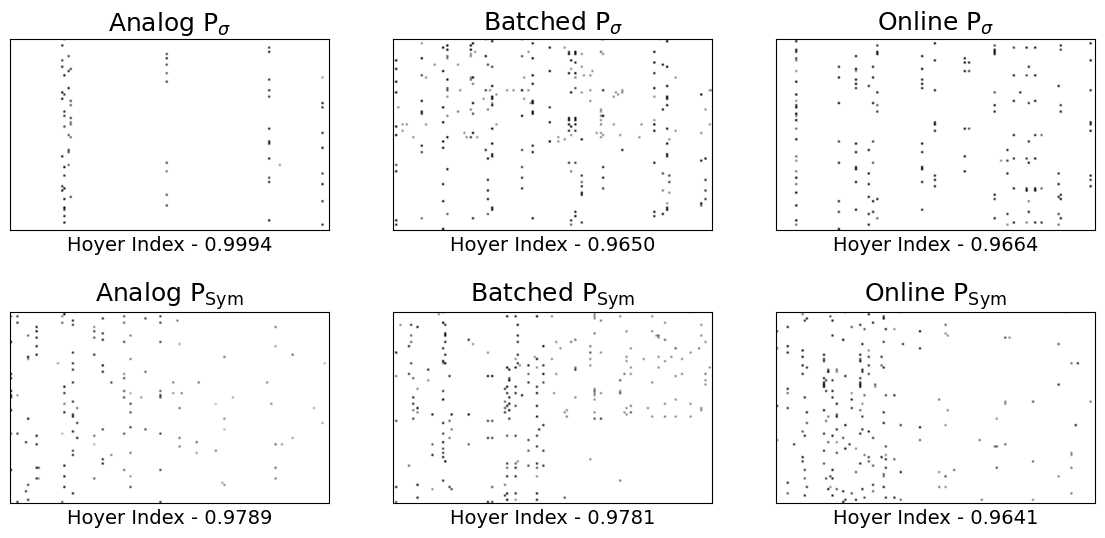

In [1]:
total = 90
limits = 25

fig, axs = plt.subplots(2, 3, figsize = (14, 6.5))

# We employ SQRTs to enhance visibility of the spikes.
# Hoyer indices are included based on the code below this cell

axs[0,0].imshow(latents_standard[:total, limits:200-limits].sqrt().sqrt(), cmap="binary")
axs[0,0].set_title("Analog $\\text{P}_{\\sigma}$" , fontsize = 18)
axs[0,0].set_xlabel("Hoyer Index - 0.9994", fontsize = 14)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])

axs[0,1].imshow(all_latents[2][:total,limits:200-limits].sqrt().sqrt(), cmap="binary")
axs[0,1].set_title("Batched $\\text{P}_{\\sigma}$", fontsize = 18) 
axs[0,1].set_xlabel("Hoyer Index - 0.9650", fontsize = 14)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])

axs[0,2].imshow(all_latents[4][:total,limits:200-limits].sqrt().sqrt(), cmap="binary")
axs[0,2].set_title("Online $\\text{P}_{\\sigma}$", fontsize = 18) 
axs[0,2].set_xlabel("Hoyer Index - 0.9664", fontsize = 14)
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])



axs[1,0].imshow(latents_sym[:total,limits:200-limits].sqrt().sqrt(), cmap="binary")
axs[1,0].set_title("Analog $\\text{P}_{\\text{Sym}}$", fontsize = 18)
axs[1,0].set_xlabel("Hoyer Index - 0.9789", fontsize = 14)
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])

axs[1,1].imshow(all_latents[1][:total,limits:200-limits].sqrt().sqrt(), cmap="binary")
axs[1,1].set_title("Batched $\\text{P}_{\\text{Sym}}$", fontsize = 18) 
axs[1,1].set_xlabel("Hoyer Index - 0.9781", fontsize = 14)
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])


axs[1,2].imshow(all_latents[3][:total,limits:200-limits].sqrt().sqrt(), cmap="binary")
axs[1,2].set_title("Online $\\text{P}_{\\text{Sym}}$", fontsize = 18) 
axs[1,2].set_xlabel("Hoyer Index - 0.9641", fontsize = 14)
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])

# Save to pdf
plt.savefig("imgs/latents_plots_fainal.pdf", bbox_inches = 'tight')

In [44]:
import numpy as np

def hoyer_index(latents):
    num_samples, num_neurons = latents.shape
    l1_norm = torch.norm(latents, p=1, dim = 1)
    l2_norm = torch.norm(latents, p=2, dim = 1)
    
    return ((np.sqrt(200)-((l1_norm+0.001) / (l2_norm+0.001)))/(np.sqrt(200)-1)).mean()

print(f"Hoyer index of analog sigma {hoyer_index(latents_standard)}")
print(f"Hoyer index of batched sigma {hoyer_index(all_latents[2])}")
print(f"Hoyer index of online sigma {hoyer_index(all_latents[4])}")

print(f"Hoyer index of analog sym {hoyer_index(latents_sym)}")
print(f"Hoyer index of batched sym {hoyer_index(all_latents[1])}")
print(f"Hoyer index of online sym {hoyer_index(all_latents[3])}")

Hoyer index of analog sigma 0.999411940574646
Hoyer index of batched sigma 0.9650235176086426
Hoyer index of online sigma 0.9664104580879211
Hoyer index of analog sym 0.9789406061172485
Hoyer index of batched sym 0.9781830310821533
Hoyer index of online sym 0.9641135931015015


### Separability Indices 

In [76]:
import math
from scipy.spatial.distance import cdist
from tqdm import tqdm

def compute_separability(latent, labels, kfactor = 5, batch_size = 32, limit = 100000):
    """ Compute the separability of the latents by using the separability index"""
    
    latents_pre, labels_pre, positiveness_pre = latent, _, labels
    
    latents, labels, positiveness = latents_pre, _, positiveness_pre
    
    total_dist = 0

    for j in tqdm(range(latent.shape[0])):
        if j > limit: break
        # Get closer indexes
        indexes = np.argsort(cdist(latents[j].reshape(1,-1), latents).reshape(-1))[1:1+kfactor]
        
        # Check with of possitiveness[index] are the same as positiveness[j]
        equals_indexes = (positiveness[j] == positiveness[indexes])
        total_dist += equals_indexes.sum()
        
    return total_dist / (kfactor * latents.shape[0])

In [78]:
print(f"Separability of sigma analog {compute_separability(latents_standard, labels_standard)}")
print(f"Separability of sigma batched {compute_separability(all_latents[2], all_labels[2])}")
print(f"Separability of sigma online {compute_separability(all_latents[4], all_labels[4])}")

print(f"Separability of sym analog {compute_separability(latents_sym, labels_sym)}")
print(f"Separability of sym batched {compute_separability(all_latents[1], all_labels[1])}")
print(f"Separability of sym online {compute_separability(all_latents[3], all_labels[3])}")

100%|██████████| 10000/10000 [01:18<00:00, 126.91it/s]


Separability of sigma analog 0.9556000232696533


100%|██████████| 10000/10000 [01:11<00:00, 140.24it/s]


Separability of sigma batched 0.996940016746521


100%|██████████| 10000/10000 [01:07<00:00, 148.18it/s]


Separability of sigma online 0.9973999857902527


100%|██████████| 10000/10000 [01:06<00:00, 149.93it/s]


Separability of sym analog 0.986519992351532


100%|██████████| 10000/10000 [01:06<00:00, 149.54it/s]


Separability of sym batched 0.9649800062179565


100%|██████████| 10000/10000 [01:07<00:00, 148.07it/s]

Separability of sym online 0.9822199940681458


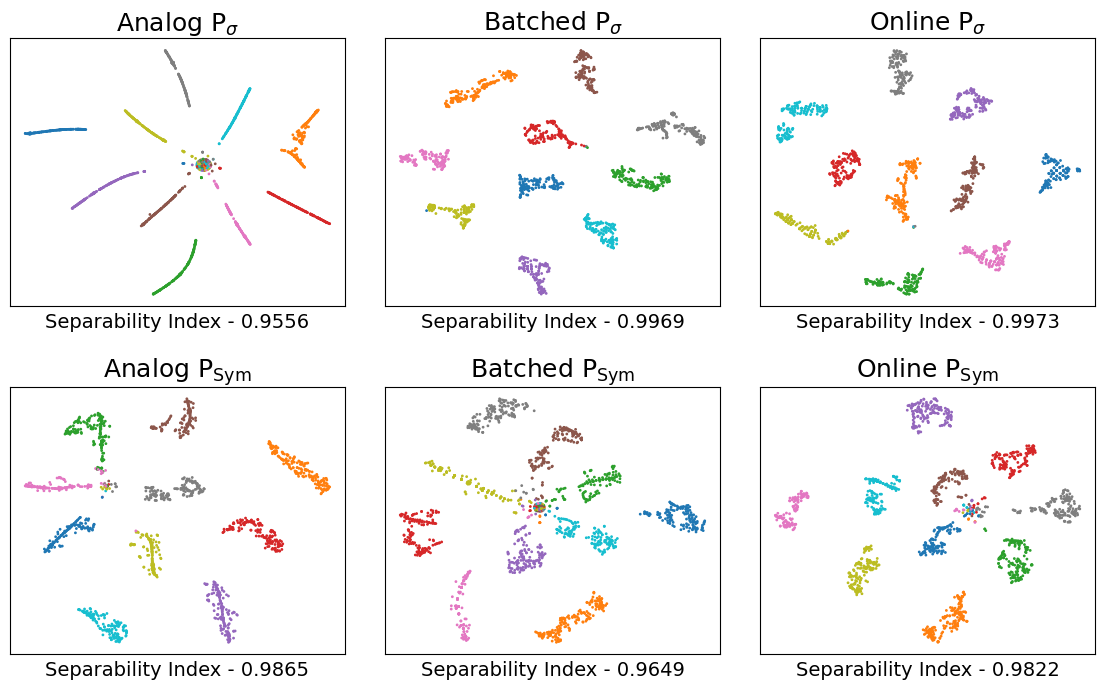

In [3]:
# Compute the TSNE of each previous latent and plot it
from sklearn.manifold import TSNE
import torch
from matplotlib import pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
total = 1500

# Open all Latent Spaces 
latents_standard = torch.load("results/latents/latents_standard_relu.pt")
labels_standard = torch.load("results/latents/label_class_standard_relu.pt")
latents_sym = torch.load("results/latents/latents_sym_relu.pt")
labels_sym = torch.load("results/latents/label_class_sym_relu.pt")

all_latents = torch.load("results/latents/latents_agg.pt")
all_labels = torch.load("results/latents/labels_nn.pt")

fig, axs = plt.subplots(2, 3, figsize = (14, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.12)

coords = tsne.fit_transform(latents_standard[:total,])

axs[0,0].scatter(coords[:,0], coords[:,1], s=1, c = labels_standard[:total], cmap = "tab10")
axs[0,0].set_title("Analog $\\text{P}_{\\sigma}$", fontsize = 18)
axs[0,0].set_xlabel("Separability Index - 0.9556", fontsize = 14)

# remove ticks
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])



coords = tsne.fit_transform(all_latents[2][:total,])
axs[0,1].scatter(coords[:,0], coords[:,1], s=1, c = all_labels[2][:total], cmap = "tab10")
axs[0,1].set_title("Batched $\\text{P}_{\\sigma}$", fontsize = 18) 
axs[0,1].set_xlabel("Separability Index - 0.9969", fontsize = 14)


# remove ticks
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])

coords = tsne.fit_transform(all_latents[4][:total,])
axs[0,2].scatter(coords[:,0], coords[:,1], s=1, c = all_labels[4][:total], cmap = "tab10")
axs[0,2].set_title("Online $\\text{P}_{\\sigma}$", fontsize = 18) 
axs[0,2].set_xlabel("Separability Index - 0.9973", fontsize = 14)

# remove ticks
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])



coords = tsne.fit_transform(latents_sym[:total,])
axs[1,0].scatter(coords[:,0], coords[:,1], s=1, c = labels_sym[:total], cmap = "tab10")
axs[1,0].set_title("Analog $\\text{P}_{\\text{Sym}}$", fontsize = 18)
axs[1,0].set_xlabel("Separability Index - 0.9865", fontsize = 14)

# remove ticks
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])

coords = tsne.fit_transform(all_latents[1][:total,])
axs[1,1].scatter(coords[:,0], coords[:,1], s=1, c = all_labels[1][:total], cmap = "tab10")
axs[1,1].set_title("Batched $\\text{P}_{\\text{Sym}}$", fontsize = 18) 
axs[1,1].set_xlabel("Separability Index - 0.9649", fontsize = 14)

# remove ticks
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])


coords = tsne.fit_transform(all_latents[3][:total,])
axs[1,2].scatter(coords[:,0], coords[:,1], s=1, c = all_labels[3][:total], cmap = "tab10")
axs[1,2].set_title("Online $\\text{P}_{\\text{Sym}}$", fontsize = 18) 
axs[1,2].set_xlabel("Separability Index - 0.9822", fontsize = 14)

# remove ticks
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])

# Save to pdf
plt.savefig("imgs/latents_tsne_fainal.pdf", bbox_inches = 'tight')